In [1]:
from sqlalchemy import create_engine
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import precision_recall_curve



conn = create_engine('postgresql://ubuntu@52.53.236.232:5432/collegesc')

%matplotlib inline

## Helper functions and other definitions

In [2]:
def query_data_def(conn, var_name):
    """
    var_name: name of column to query
    returns query from datadefinitions table showing definition of data
    """
    query = "SELECT * FROM datadefinitions WHERE developername='"+var_name+"';"
    return conn.execute(query).fetchall()

def check_highnull_columns(df, threshold=1000):
    """
    takes a dataframe and checks which columns
    have lower than threshold nulls
    returns partial dataframe with columns with low nulls
    """
    return df.loc[:, df.isnull().sum() < threshold]

## Start with school table

In [3]:
school_all = """SELECT * FROM school;"""

In [4]:
school_df = pd.read_sql_query(school_all, conn)

In [5]:
school_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7703 entries, 0 to 7702
Data columns (total 43 columns):
index                                   7703 non-null int64
id                                      7703 non-null int64
location.lat                            7703 non-null float64
location.lon                            7703 non-null float64
accreditor                              6805 non-null object
alias                                   2178 non-null object
branches                                7703 non-null int64
carnegie_basic                          7282 non-null float64
carnegie_size_setting                   7282 non-null float64
carnegie_undergrad                      7282 non-null float64
city                                    7703 non-null object
degree_urbanization                     0 non-null object
degrees_awarded.highest                 7703 non-null int64
degrees_awarded.predominant             7703 non-null int64
degrees_awarded.predominant_recoded     0 

In [6]:
school_df.operating.value_counts()

1    6893
0     810
Name: operating, dtype: int64

### Remove uninteresting columns or columns with explicit or encoded nulls

In [7]:
school_columns = list(school_df.columns.values)

In [8]:
school_columns.remove('index')
school_columns.remove('alias')
school_columns.remove('degree_urbanization')
school_columns.remove('degrees_awarded.predominant_recoded')
school_columns.remove('faculty_salary')
school_columns.remove('ft_faculty_rate')
school_columns.remove('price_calculator_url')
school_columns.remove('url')
school_columns.remove('zip')
school_columns.remove('carnegie_basic')
school_columns.remove('carnegie_size_setting')
school_columns.remove('carnegie_undergrad')
school_columns.remove('online_only')
school_columns.remove('accreditor')
school_columns.remove('under_investigation')

## Get columns from student table next

In [11]:
student_all = "SELECT * FROM student;"

In [13]:
student_df = pd.read_sql_query(student_all, conn)

In [14]:
student_lownull_df = check_highnull_columns(student_df, threshold=2000)

In [15]:
student_lownull_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7703 entries, 0 to 7702
Data columns (total 39 columns):
index                                             7703 non-null int64
FAFSA_applications                                7204 non-null float64
avg_dependent_income.2014dollars                  6835 non-null float64
avg_independent_income.2014dollars                6835 non-null float64
demographics.age_entry                            7204 non-null float64
demographics.avg_family_income                    7204 non-null float64
demographics.avg_family_income_independents       6835 non-null float64
demographics.dependent                            6829 non-null float64
demographics.female_share                         6259 non-null float64
demographics.first_generation                     6534 non-null float64
demographics.married                              6495 non-null float64
demographics.median_family_income                 7204 non-null float64
demographics.men               

In [16]:
student_lownull_df['parents_education_level'].describe()

count      6568.000000
mean       4959.635201
std       12477.427315
min          11.000000
25%         320.000000
50%        1074.000000
75%        3380.000000
max      136770.000000
Name: parents_education_level, dtype: float64

In [63]:
student_lownull = list(student_lownull_df.columns.values)

In [64]:
student_lownull.remove('index')
student_lownull.remove('avg_dependent_income.2014dollars')
student_lownull.remove('demographics.avg_family_income')
student_lownull.remove('demographics.avg_family_income_independents')
student_lownull.remove('avg_independent_income.2014dollars')
student_lownull.remove('FAFSA_applications')
student_lownull.remove('family_income.dependent_students')
student_lownull.remove('family_income.independent_students')
student_lownull.remove('family_income.overall')
student_lownull.remove('valid_dependency_status')
student_lownull.remove('parents_education_level')
student_lownull.remove('id')
student_lownull

['demographics.age_entry',
 'demographics.dependent',
 'demographics.female_share',
 'demographics.first_generation',
 'demographics.married',
 'demographics.median_family_income',
 'demographics.men',
 'demographics.race_ethnicity.aian',
 'demographics.race_ethnicity.asian',
 'demographics.race_ethnicity.black',
 'demographics.race_ethnicity.hispanic',
 'demographics.race_ethnicity.nhpi',
 'demographics.race_ethnicity.non_resident_alien',
 'demographics.race_ethnicity.two_or_more',
 'demographics.race_ethnicity.unknown',
 'demographics.race_ethnicity.white',
 'demographics.women',
 'fafsa_sent.2_college_allyrs',
 'part_time_share',
 'share_25_older',
 'share_firstgeneration',
 'share_firstgeneration_parents.somecollege',
 'share_independent_students',
 'share_lowincome.0_30000',
 'share_middleincome.30001_48000',
 'size',
 'students_with_pell_grant']

## Select only interesting features and add/recode features

In [65]:
operating_query = 'SELECT \n school."' + '",school."'.join(school_columns) + '",repayment."3_yr_default_rate"'
operating_query += ', aid."federal_loan_rate", aid."pell_grant_rate",student."'
operating_query += '",student."'.join(student_lownull)+'"'
operating_query += """                       
                    FROM 
                        school
                    JOIN repayment ON school.id=repayment.id
                    JOIN aid ON school.id=aid.id
                    JOIN student ON school.id=student.id;"""
operating_query

'SELECT \n school."id",school."location.lat",school."location.lon",school."branches",school."city",school."degrees_awarded.highest",school."degrees_awarded.predominant",school."institutional_characteristics.level",school."instructional_expenditure_per_fte",school."locale",school."main_campus",school."men_only",school."minority_serving.aanipi",school."minority_serving.annh",school."minority_serving.hispanic",school."minority_serving.historically_black",school."minority_serving.nant",school."minority_serving.predominantly_black",school."minority_serving.tribal",school."name",school."operating",school."ownership",school."region_id",school."religious_affiliation",school."state",school."state_fips",school."tuition_revenue_per_fte",school."women_only",repayment."3_yr_default_rate", aid."federal_loan_rate", aid."pell_grant_rate",student."demographics.age_entry",student."demographics.dependent",student."demographics.female_share",student."demographics.first_generation",student."demographics.ma

In [66]:
school_df = pd.read_sql_query(operating_query, conn)

In [67]:
school_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7703 entries, 0 to 7702
Data columns (total 58 columns):
id                                                7703 non-null int64
location.lat                                      7703 non-null float64
location.lon                                      7703 non-null float64
branches                                          7703 non-null int64
city                                              7703 non-null object
degrees_awarded.highest                           7703 non-null int64
degrees_awarded.predominant                       7703 non-null int64
institutional_characteristics.level               7703 non-null int64
instructional_expenditure_per_fte                 7270 non-null float64
locale                                            7282 non-null float64
main_campus                                       7703 non-null int64
men_only                                          7282 non-null float64
minority_serving.aanipi                   

### Recode locale to 4 values instead of 12

In [68]:
locale_recode = school_df.locale.astype(str).values

In [69]:
locale_recode = [int(x[0]) if x[0] in ['1','2','3'] else 0 for x in locale_recode]

In [70]:
school_df['locale_recode'] = locale_recode

In [71]:
school_df['locale_recode'].value_counts()

1    3509
2    2291
0     986
3     917
Name: locale_recode, dtype: int64

### Recode religion to religious and non-religious

In [72]:
religion_recode = (np.nan_to_num(school_df.religious_affiliation.values) > 0).astype(int)

In [73]:
np.unique(religion_recode)

array([0, 1])

In [74]:
school_df['religion_recode'] = religion_recode

In [75]:
school_df.religion_recode.value_counts()

0    6793
1     910
Name: religion_recode, dtype: int64

### Check other variables

In [90]:
for column in school_df.columns:
    print(column+" value counts")
    print(school_df[column].value_counts())

id value counts
217086      1
216667      1
177588      1
449977      1
179645      1
236993      1
476610      1
107974      1
171465      1
150987      1
130509      1
169424      1
155089      1
156417      1
226772      1
452054      1
191959      1
161244      1
213491      1
480736      1
175591      1
417257      1
181738      1
194028      1
409069      1
372329      1
431600      1
230898      1
152336      1
478643      1
           ..
23368407    1
197285      1
449214      1
187046      1
189097      1
203438      1
418481      1
190044      1
139393      1
201399      1
261773      1
467641      1
457402      1
461500      1
459453      1
476902      1
127699      1
230852      1
213215      1
209603      1
182980      1
16947910    1
447175      1
174792      1
205513      1
228042      1
406219      1
16947918    1
234191      1
149505      1
Name: id, Length: 7703, dtype: int64
location.lat value counts
0.000000     421
40.760050      2
38.655362      2
32.955170      2

### Recode gender-specific schools

In [76]:
school_df['gender_specific'] = np.nan_to_num((school_df.men_only + school_df.women_only).values)

In [77]:
school_df.gender_specific.value_counts()

0.0    7598
1.0     105
Name: gender_specific, dtype: int64

### Recode minority-serving schools

In [78]:
minority_specific = np.nan_to_num((school_df['minority_serving.aanipi'] +\
                        school_df['minority_serving.annh'] +\
                        school_df['minority_serving.hispanic'] +\
                        school_df['minority_serving.historically_black'] +\
                        school_df['minority_serving.nant'] +\
                        school_df['minority_serving.predominantly_black'] +\
                        school_df['minority_serving.tribal']).values)

In [79]:
minority_specific = (minority_specific > 0).astype(int)

In [80]:
school_df['minority_specific'] = minority_specific

### Recode for-profit vs. non-profit (private or public)

In [81]:
school_df['for_profit'] = (school_df.ownership == 3).astype(int)

In [82]:
school_df.for_profit.value_counts()

0    4000
1    3703
Name: for_profit, dtype: int64

### Impute continuous variables with mean

In [95]:
continuous_vars = ['instructional_expenditure_per_fte', 'tuition_revenue_per_fte', '3_yr_default_rate',
                  'federal_loan_rate', 'pell_grant_rate', 'demographics.age_entry', 
                  'demographics.dependent', 'demographics.female_share', 'demographics.married',
                  'demographics.median_family_income', 'demographics.race_ethnicity.aian',
                   'demographics.race_ethnicity.asian','demographics.race_ethnicity.black',
                   'demographics.race_ethnicity.hispanic','demographics.race_ethnicity.nhpi',
                   'demographics.race_ethnicity.non_resident_alien',
                   'demographics.race_ethnicity.two_or_more',
                   'demographics.race_ethnicity.unknown','demographics.race_ethnicity.white',
                   'fafsa_sent.2_college_allyrs', 'part_time_share','share_25_older',
                   'share_firstgeneration','share_firstgeneration_parents.somecollege',
                   'share_independent_students','share_lowincome.0_30000',
                   'share_middleincome.30001_48000','size','students_with_pell_grant']


In [96]:
for var in continuous_vars:
    school_df[var].fillna(school_df[var].mean(), inplace=True)
    

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


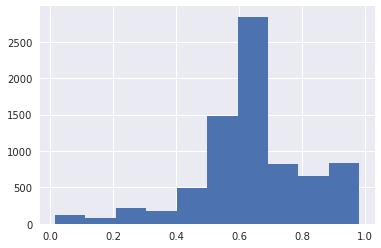

In [101]:
school_df['demographics.female_share'].hist()

In [97]:
school_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7703 entries, 0 to 7702
Data columns (total 63 columns):
id                                                7703 non-null int64
location.lat                                      7703 non-null float64
location.lon                                      7703 non-null float64
branches                                          7703 non-null int64
city                                              7703 non-null object
degrees_awarded.highest                           7703 non-null int64
degrees_awarded.predominant                       7703 non-null int64
institutional_characteristics.level               7703 non-null int64
instructional_expenditure_per_fte                 7703 non-null float64
locale                                            7282 non-null float64
main_campus                                       7703 non-null int64
men_only                                          7282 non-null float64
minority_serving.aanipi                   

### Pare down to relevant columns

In [102]:
cleaned_school_df = school_df.drop(['locale', 'men_only',
                                    'minority_serving.aanipi', 'minority_serving.annh',
                                    'minority_serving.hispanic', 'minority_serving.historically_black',
                                    'minority_serving.nant', 'minority_serving.predominantly_black',
                                    'minority_serving.tribal', 'religious_affiliation', 'state', 
                                    'state_fips','women_only', 'demographics.men',
                                    'demographics.women'], axis = 1)

In [104]:
cleaned_school_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7703 entries, 0 to 7702
Data columns (total 48 columns):
id                                                7703 non-null int64
location.lat                                      7703 non-null float64
location.lon                                      7703 non-null float64
branches                                          7703 non-null int64
city                                              7703 non-null object
degrees_awarded.highest                           7703 non-null int64
degrees_awarded.predominant                       7703 non-null int64
institutional_characteristics.level               7703 non-null int64
instructional_expenditure_per_fte                 7703 non-null float64
main_campus                                       7703 non-null int64
name                                              7703 non-null object
operating                                         7703 non-null int64
ownership                                    

In [353]:
#main_campus_df = cleaned_school_df.loc[(cleaned_school_df.branches>1) & (cleaned_school_df.main_campus == 1) | (cleaned_school_df.branches == 1)]

In [105]:
cleaned_school_df['not_operating'] =  1 - cleaned_school_df.operating

In [107]:
cleaned_school_df.not_operating.value_counts()

0    6893
1     810
Name: not_operating, dtype: int64

## Select columns for classification


In [110]:
X = cleaned_school_df.drop(['id', 'city', 'name', 'ownership', 'region_id', 'operating', 'not_operating'], axis = 1)
y = cleaned_school_df.not_operating

In [111]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

In [112]:
log_model = LogisticRegression(penalty='l1')

In [113]:
log_model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [114]:
prob_operating = log_model.predict_proba(X_test)

In [115]:
log_loss(y_test, prob_operating[:, 1])

0.27429655715491885

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


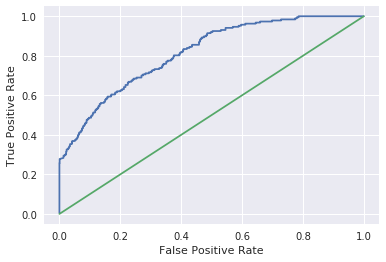

In [116]:
fpr, tpr, thresholds = roc_curve(y_test,prob_operating[:, 1])
plt.plot(fpr, tpr)
plt.plot(np.linspace(0,1,3),np.linspace(0,1,3))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

In [117]:
roc_auc_score(y_test, prob_operating[:, 1])

0.81425603677754166

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


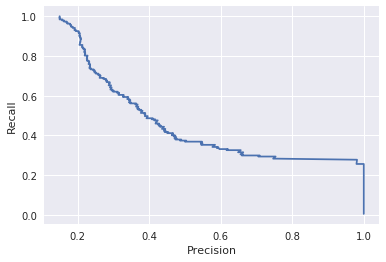

In [118]:
prec, recall, thresholds = precision_recall_curve(y_test,prob_operating[:, 1])
plt.plot(prec[0:-1], recall[0:-1])
plt.xlabel("Precision")
plt.ylabel("Recall")

In [119]:
list(zip(X.columns, log_model.coef_[0]))

[('location.lat', 0.0033193903901621706),
 ('location.lon', 0.0015702445819856799),
 ('branches', 0.030233704840436137),
 ('degrees_awarded.highest', -0.15893715140582229),
 ('degrees_awarded.predominant', -0.27701496337396575),
 ('institutional_characteristics.level', 0.275082196484569),
 ('instructional_expenditure_per_fte', 1.915780199768459e-06),
 ('main_campus', -0.30134585240238582),
 ('tuition_revenue_per_fte', 2.1837299768117421e-05),
 ('3_yr_default_rate', 1.7708706108909689),
 ('federal_loan_rate', 0.0),
 ('pell_grant_rate', 0.88046882547652094),
 ('demographics.age_entry', -0.053738341620895594),
 ('demographics.dependent', 0.0),
 ('demographics.female_share', 0.2158900064608501),
 ('demographics.first_generation', 0.0),
 ('demographics.married', 0.0),
 ('demographics.median_family_income', -4.1152498495852678e-05),
 ('demographics.race_ethnicity.aian', 0.0),
 ('demographics.race_ethnicity.asian', 0.19676328353949346),
 ('demographics.race_ethnicity.black', 0.0),
 ('demograp

In [120]:
y_test.sum()/len(y_test)

0.12134977287475665

In [121]:
y_train.sum()/len(y_train)

0.10110353781239857